In [45]:
import pandas as pd

                     y1       y2        y3        y4
XGBClassifier  0.027695  0.03781  0.046246  0.061747
                         y1        y2        y3        y4
Age                0.026343  0.031398  0.038185  0.059162
CAD                     NaN       NaN       NaN       NaN
DM                 0.027667       NaN       NaN       NaN
DTI                     NaN  0.044423       NaN       NaN
F.Hosp                  NaN  0.030378  0.034736  0.048509
FXaI               0.040788  0.055241  0.048378  0.063307
Group              0.027695  0.037810  0.046246  0.061747
HF                      NaN       NaN       NaN  0.052097
HTN                0.026158       NaN  0.030704  0.048236
Lung Tumor              NaN       NaN  0.031404  0.067596
No CVD MD          0.028016  0.030602  0.029902  0.046891
No TD              0.545295  0.475459  0.502815  0.295372
Non Solid Tumor    0.048330  0.051488  0.042150       NaN
OCD                     NaN       NaN       NaN       NaN
Other Solid Tumor       

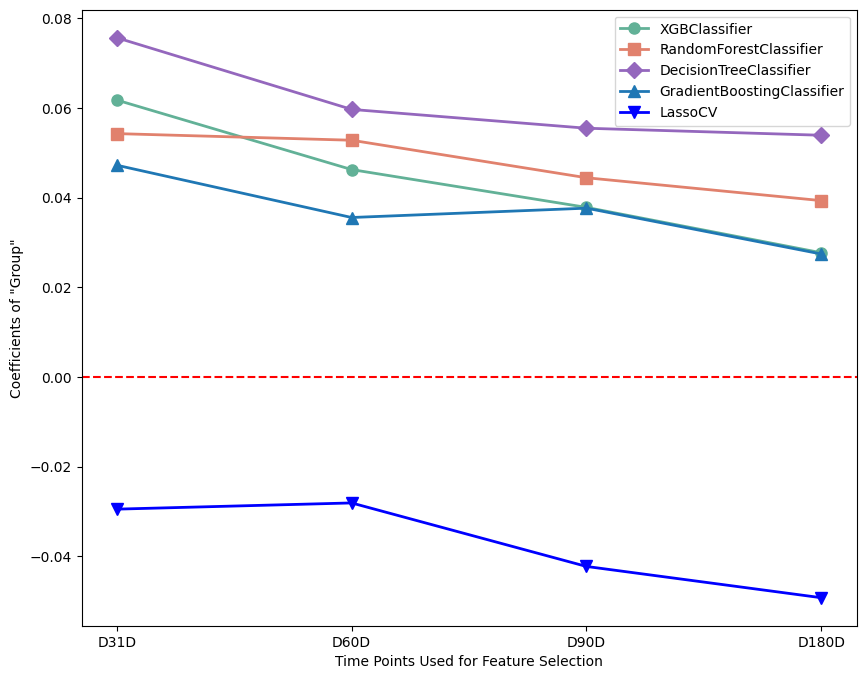

In [182]:
# 读取C:\MyProject\MIMIC-IPE\加了中介变量的数据集\用于特征选择的数据集.csv
data = pd.read_csv('C:/MyProject/MIMIC-IPE/加了中介变量的数据集/用于特征选择的数据集.csv')

# 查看data中所有的列名，并计算列中空值计数，赋值给一个dataframe
data_info = pd.DataFrame(data.columns, columns=['columns'])
data_info['null_count'] = [data[col].isnull().sum() for col in data.columns]

'''
以下列为特征列，赋值给X
Group
F.Hosp
DTI
FXaI
UFH
VKA
Age
Lung Tumor
No TD
Non Solid Tumor
Other Solid Tumor
OCD
PT
TTP
CAD
DM
HF
HTN
No CVD MD
PAD
'''
# List of column names to be assigned to X
feature_columns = [
    'Group',
    'F.Hosp',
    'DTI',
    'FXaI',
    'UFH',
    'VKA',
    'Age',
    'Lung Tumor',
    'No TD',
    'Non Solid Tumor',
    'Other Solid Tumor',
    'OCD',
    'PT',
    'TTP',
    'CAD',
    'DM',
    'HF',
    'HTN',
    'No CVD MD',
    'PAD'
]

# Assign these columns to X
X = data[feature_columns]
# D60M为生存状态，赋值给y
y1 = data['D180D']
y2 = data['D90D']
y3 = data['D60D']
y4 = data['D31D']

import pandas as pd
from xgboost import XGBClassifier as xgb

# 创建一个空的DataFrame，列是不同的时间点
xgb_df = pd.DataFrame(columns=['y1', 'y2', 'y3', 'y4'])

# 创建一个新的DataFrame，用于存储所有目标变量的特征重要性
xgb_feature = pd.DataFrame(index=X.columns)

def feature_selection(y, random_seed):
    # 创建XGBClassifier实例，并设置随机种子
    clf = xgb(random_state=random_seed)

    # 在数据上拟合分类器
    clf.fit(X, y)

    # 获取特征重要性
    feature_importances = clf.feature_importances_

    # 创建一个DataFrame来显示特征及其重要性
    feature_importance_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importances})

    # 根据特征的重要性对DataFrame进行排序
    feature_importance_df.sort_values(by="Importance", ascending=False, inplace=True)

    # 只保留重要性大于或等于0.01的特征
    feature_importance_df = feature_importance_df[feature_importance_df["Importance"] >= 0.01]

    # 只保留排名前10的特征
    feature_importance_df = feature_importance_df.head(10)

    # 获取'Group'特征的重要性
    group_importance = feature_importance_df.loc[feature_importance_df['Feature'] == 'Group', 'Importance'].values[0]

    return group_importance, feature_importance_df.set_index('Feature')

# List of target variables
ys = [y1, y2, y3, y4]

# List to store the importance of the 'Group' feature for each target variable
group_importances = []

# Set a random seed
random_seed = 42

for i, y in enumerate(ys):
    group_importance, feature_importance_df = feature_selection(y, random_seed)
    group_importances.append(group_importance)

    # 将特征重要性的DataFrame添加到新的DataFrame中
    xgb_feature = xgb_feature.join(feature_importance_df.rename(columns={'Importance': f'y{i+1}'}), how='outer')

# 将结果添加到DataFrame中
xgb_df.loc['XGBClassifier'] = group_importances

# 输出DataFrame
print(xgb_df)

# 输出所有目标变量的特征重要性
print(xgb_feature)
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# 创建一个空的DataFrame，列是不同的时间点
rf_df = pd.DataFrame(columns=['y1', 'y2', 'y3', 'y4'])

# 创建一个新的DataFrame，用于存储所有目标变量的特征重要性
rf_feature = pd.DataFrame(index=X.columns)

def feature_selection(y):
    # 创建随机森林分类器实例
    clf = RandomForestClassifier()

    # 使用随机森林分类器拟合数据
    clf.fit(X, y)

    # 获取特征重要性
    feature_importances = clf.feature_importances_

    # 创建一个数据框来显示特征和它们的重要性
    feature_importance_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importances})

    # 按重要性降序排序
    feature_importance_df.sort_values(by="Importance", ascending=False, inplace=True)

    # 获取'Group'特征的重要性
    group_importance = feature_importance_df.loc[feature_importance_df['Feature'] == 'Group', 'Importance'].values[0]

    # 只保留排名前10的特征
    feature_importance_df = feature_importance_df.head(10)

    return group_importance, feature_importance_df.set_index('Feature')

# 目标变量列表
ys = [y1, y2, y3, y4]

# 存储每个目标变量的'Group'特征重要性的列表
group_importances = []

for i, y in enumerate(ys):
    group_importance, feature_importance_df = feature_selection(y)
    group_importances.append(group_importance)

    # 将特征重要性的DataFrame添加到新的DataFrame中
    rf_feature = rf_feature.join(feature_importance_df.rename(columns={'Importance': f'y{i+1}'}), how='outer')

# 将结果添加到DataFrame中
rf_df.loc['RandomForestClassifier'] = group_importances

# 输出DataFrame
print(rf_df)

# 输出所有目标变量的特征重要性
print(rf_feature)
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

# 创建一个空的DataFrame，列是不同的时间点
dtc_df = pd.DataFrame(columns=['y1', 'y2', 'y3', 'y4'])

# 创建一个新的DataFrame，用于存储所有目标变量的特征重要性
dtc_feature = pd.DataFrame(index=X.columns)

def feature_selection(y):
    # 创建决策树分类器实例
    dtc = DecisionTreeClassifier()

    # 在数据上拟合分类器
    dtc.fit(X, y)

    # 获取特征重要性
    feature_importances = dtc.feature_importances_

    # 创建一个DataFrame来显示特征及其重要性
    feature_importance_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importances})

    # 按重要性降序排序
    feature_importance_df.sort_values(by="Importance", ascending=False, inplace=True)

    # 只保留排名前10的特征
    feature_importance_df = feature_importance_df.head(10)

    # 获取'Group'特征的重要性
    group_importance = feature_importance_df.loc[feature_importance_df['Feature'] == 'Group', 'Importance'].values[0]

    return group_importance, feature_importance_df.set_index('Feature')

# 目标变量列表
ys = [y1, y2, y3, y4]

# 存储每个目标变量的'Group'特征重要性的列表
group_importances = []

for i, y in enumerate(ys):
    group_importance, feature_importance_df = feature_selection(y)
    group_importances.append(group_importance)

    # 将特征重要性的DataFrame添加到新的DataFrame中
    dtc_feature = dtc_feature.join(feature_importance_df.rename(columns={'Importance': f'y{i+1}'}), how='outer')

# 将结果添加到DataFrame中
dtc_df.loc['DecisionTreeClassifier'] = group_importances

# 输出DataFrame
print(dtc_df)

# 输出所有目标变量的特征重要性
print(dtc_feature)
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier

# 创建一个空的DataFrame，列是不同的时间点
gbdt_df = pd.DataFrame(columns=['y1', 'y2', 'y3', 'y4'])

# 创建一个新的DataFrame，用于存储所有目标变量的特征重要性
gbdt_feature = pd.DataFrame(index=X.columns)

def feature_selection(y):
    # 创建GBDT分类器实例
    gbdt = GradientBoostingClassifier()

    # 在数据上拟合分类器
    gbdt.fit(X, y)

    # 获取特征重要性
    feature_importances = gbdt.feature_importances_

    # 创建一个DataFrame来显示特征及其重要性
    feature_importance_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importances})

    # 根据特征的重要性对DataFrame进行排序
    feature_importance_df.sort_values(by="Importance", ascending=False, inplace=True)

    # 只保留排名前10的特征
    feature_importance_df = feature_importance_df.head(10)

    # 获取'Group'特征的重要性
    group_importance = feature_importance_df.loc[feature_importance_df['Feature'] == 'Group', 'Importance'].values[0]

    return group_importance, feature_importance_df.set_index('Feature')

# 目标变量列表
ys = [y1, y2, y3, y4]

# 存储每个目标变量的'Group'特征重要性的列表
group_importances = []

for i, y in enumerate(ys):
    group_importance, feature_importance_df = feature_selection(y)
    group_importances.append(group_importance)

    # 将特征重要性的DataFrame添加到新的DataFrame中
    gbdt_feature = gbdt_feature.join(feature_importance_df.rename(columns={'Importance': f'y{i+1}'}), how='outer')

# 将结果添加到DataFrame中
gbdt_df.loc['GradientBoostingClassifier'] = group_importances

# 输出DataFrame
print(gbdt_df)

# 输出所有目标变量的特征重要性
print(gbdt_feature)
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel

# 创建一个空的DataFrame，列是不同的时间点
lasso_df = pd.DataFrame(columns=['y1', 'y2', 'y3', 'y4'])

# 创建一个新的DataFrame，用于存储所有目标变量的特征重要性
lasso_feature = pd.DataFrame(index=X.columns)

def feature_selection(y):
    # 创建LassoCV实例
    lasso = LassoCV(cv=5)

    # 在数据上拟合LassoCV
    lasso.fit(X, y)

    # 获取LassoCV模型的系数
    coefficients = lasso.coef_

    # 创建一个DataFrame来显示特征及其系数
    coefficients_df = pd.DataFrame({"Feature": X.columns, "Coefficient": coefficients})  # 移除了abs函数

    # 使用LassoCV创建SelectFromModel实例
    selector = SelectFromModel(lasso)

    # 在数据上拟合选择器
    selector.fit(X, y)

    # 获取支持掩码
    support_mask = selector.get_support()

    # 获取选定的特征名称
    selected_features = X.columns[support_mask]

    # 只保留被选中的特征的系数
    selected_coefficients_df = coefficients_df[coefficients_df["Feature"].isin(selected_features)]

    # 获取'Group'特征的系数
    group_coefficient = selected_coefficients_df.loc[selected_coefficients_df['Feature'] == 'Group', 'Coefficient'].values[0]

    return group_coefficient, selected_coefficients_df.set_index('Feature')

# 目标变量列表
ys = [y1, y2, y3, y4]

# 存储每个目标变量的'Group'特征系数的列表
group_coefficients = []

for i, y in enumerate(ys):
    group_coefficient, coefficients_df = feature_selection(y)
    group_coefficients.append(group_coefficient)

    # 将特征系数的DataFrame添加到新的DataFrame中
    lasso_feature = lasso_feature.join(coefficients_df.rename(columns={'Coefficient': f'y{i+1}'}), how='outer')

# 将结果添加到DataFrame中
lasso_df.loc['LassoCV'] = group_coefficients

# 输出DataFrame
print(lasso_df)

# 输出所有目标变量的特征重要性
print(lasso_feature)
# 将将xgb_df，rf_df，dtc_df，gbdt_df，lasso_df合并到一个DataFrame中
dfs = [xgb_df, rf_df, dtc_df, gbdt_df, lasso_df]
result = pd.concat(dfs)
# 更改列名，y1改为D180D，y2改为D90D，y3改为D60D，y4改为D31D
result.columns = ['D180D', 'D90D', 'D60D', 'D31D']
# 将列的顺序改为D31D，D60D，D90D，D180D
result = result[['D31D', 'D60D', 'D90D', 'D180D']]
# 转置
#result = result.T
# print
print(result)
# 保存到C:\MyProject\MIMIC-IPE\results\特征选择结果.csv
result.to_csv('C:/MyProject/MIMIC-IPE/results/特征选择结果.csv')
# 合并xgb_feature、rf_feature、dtc_feature、gbdt_feature、lasso_feature到一个excel的不同sheet中
with pd.ExcelWriter('C:/MyProject/MIMIC-IPE/results/特征重要性.xlsx') as writer:
    xgb_feature.to_excel(writer, sheet_name='XGBClassifier')
    rf_feature.to_excel(writer, sheet_name='RandomForestClassifier')
    dtc_feature.to_excel(writer, sheet_name='DecisionTreeClassifier')
    gbdt_feature.to_excel(writer, sheet_name='GradientBoostingClassifier')
    lasso_feature.to_excel(writer, sheet_name='LassoCV')
import matplotlib.pyplot as plt
import random

# 创建一个包含指定颜色和随机颜色的颜色列表
colors = ["#62B197", "#E1816D", "#9467BD", "#1F77B4", "#0000FF"]

# 准备数据
result_transposed = result.T

# 创建线形图
plt.figure(figsize=(10, 8))

# 不同形状的标记
markers = ['o', 's', 'D', '^', 'v']

for i, column in enumerate(result_transposed.columns):
    plt.plot(result_transposed.index, result_transposed[column], label=column, color=colors[i], linewidth=2, marker=markers[i], markersize=8)

plt.xlabel('Time Points Used for Feature Selection')
plt.ylabel('Coefficients of "Group"')

# 添加水平的0刻度线
plt.axhline(0, color='r', linestyle='--')

plt.legend(title='Methods')
# 图例放在最理想的位置
plt.legend(loc='best')

# 显示图形
plt.show()


In [18]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

def feature_selection(y):
    # 创建RFECV实例
    rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(10), scoring='accuracy')

    # 在数据上拟合RFECV
    rfecv.fit(X, y)

    # 获取特征的排名
    ranking = rfecv.ranking_

    # 创建一个DataFrame来显示特征及其排名
    ranking_df = pd.DataFrame({"Feature": X.columns, "Ranking": ranking})

    # 获取'Group'特征的排名
    group_ranking = ranking_df.loc[ranking_df['Feature'] == 'Group', 'Ranking'].values[0]

    return group_ranking

# 目标变量列表
ys = [y1, y2, y3, y4]

# 存储每个目标变量的'Group'特征排名的列表
group_rankings = []

for y in ys:
    group_ranking = feature_selection(y)
    group_rankings.append(group_ranking)

# 绘制排名
plt.plot(['y1', 'y2', 'y3', 'y4'], group_rankings)

# 为每个点添加标记
plt.scatter(['y1', 'y2', 'y3', 'y4'], group_rankings)

# 使用它们的值注释点
for i, txt in enumerate(group_rankings):
    plt.annotate(txt, (['y1', 'y2', 'y3', 'y4'][i], group_rankings[i]))

plt.xlabel('Target Variable')
plt.ylabel('Ranking of Group Feature')
plt.title('Ranking of Group Feature for Different Target Variables')
plt.show()

NameError: name 'clf' is not defined